In [1]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
import seaborn as sns

from os.path import join

from eyefeatures.preprocessing.fixation_extraction import IVT
from eyefeatures.visualization.static_visualization import scanpath_visualization
from eyefeatures.preprocessing.aoi_extraction import ThresholdBased, GradientBased, OverlapClustering, ShapeBased, AOIExtractor, AOIMatcher

DATA_PATH = join('..', 'data', 'gazes')

In [2]:
def remove_points(df, x_min, x_max, y_min, y_max):
    df = df[df['norm_pos_x'] <= x_max]
    df = df[df['norm_pos_x'] >= x_min]
    df = df[df['norm_pos_y'] >= y_min]
    df = df[df['norm_pos_y'] <= y_max]
    return df

data = pd.concat([pd.read_excel(join(DATA_PATH, 'itog_gaze_1.xlsx')),
                  pd.read_excel(join(DATA_PATH, 'itog_gaze_2.xlsx')),
                  ], axis=0)

data.drop(['world_index', 'confidence', 'base_data'], axis=1, inplace=True)
data = remove_points(data, -1, 1, -1, 1)
data['gaze_timestamp'] = data['gaze_timestamp']
x = 'norm_pos_x'
y = 'norm_pos_y'
t = 'gaze_timestamp'

In [3]:
shape_based = ShapeBased(x, y, shapes=[[['r', (0., 0.), (1., 0.6)], ('r', (0., 0.), (1., 0.3)), ('r', (0., 0.), (1., 0.)),],], pk=['tekst'], aoi_name="AOI") 
tt = shape_based.transform(data)

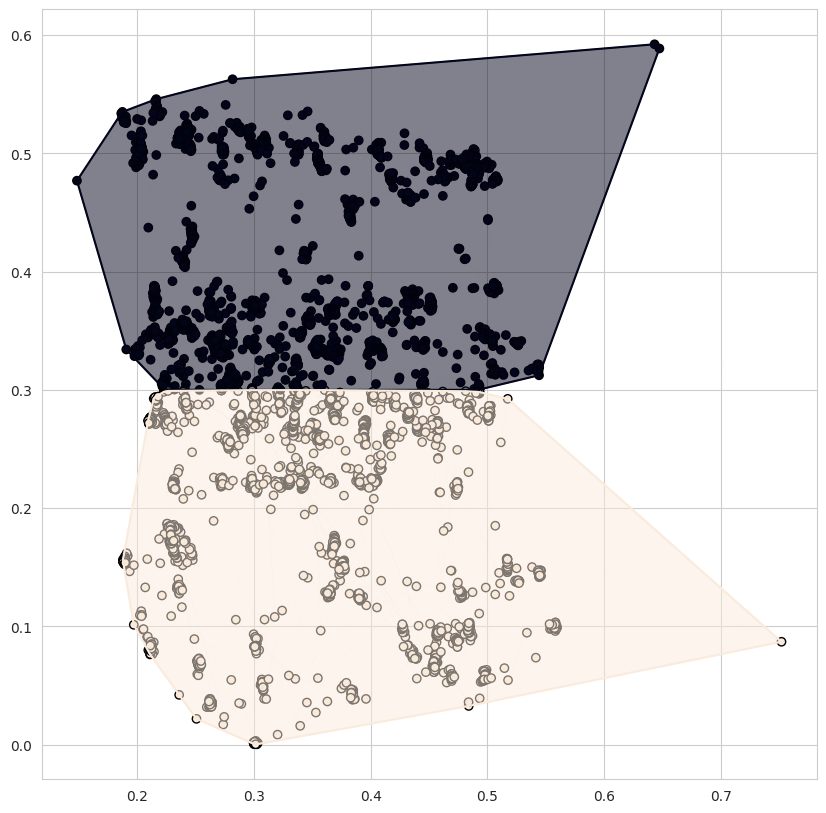

In [4]:
scanpath_visualization(tt[(tt['Participant'] == 1) & (tt['tekst'] == 1)], x="norm_pos_x", y="norm_pos_y", aoi="AOI", show_hull=True, with_axes=True)

In [5]:
shape_based = ShapeBased(x, y, shapes=[[['c', (0.3, 0.35), 0.05], ['c', (0.5, 0.35), 0.05], ['c', (0.45, 0.05), 0.1],],], pk=['tekst'], aoi_name="AOI") 
tt = shape_based.transform(data)

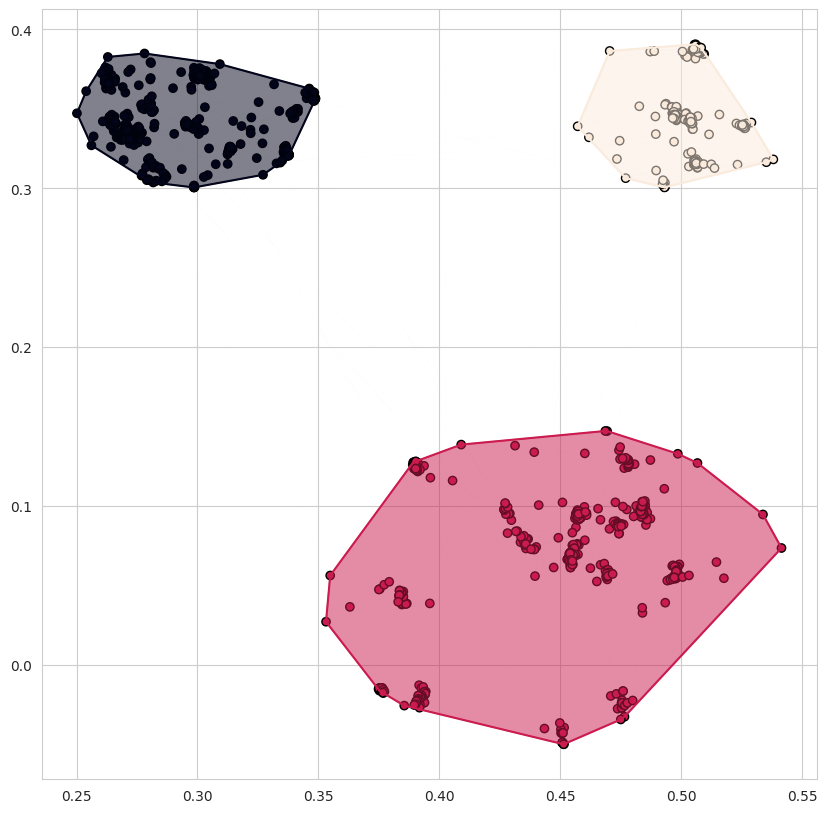

In [6]:
scanpath_visualization(tt[(tt['Participant'] == 1) & (tt['tekst'] == 1)], x="norm_pos_x", y="norm_pos_y", aoi="AOI", show_hull=True, with_axes=True)

In [7]:
shape_based = ShapeBased(x, y, shapes=[[['e', (0.3, 0.35), 0.3, 0.35, 1., 0.05], ['e', (0.5, 0.35), 0.5, 0.35, 1., 0.05], ['e', (0.45, 0.05), 0.45, 0.05, 1., 0.1],],], pk=['tekst'], aoi_name="AOI") 
tt = shape_based.transform(data)

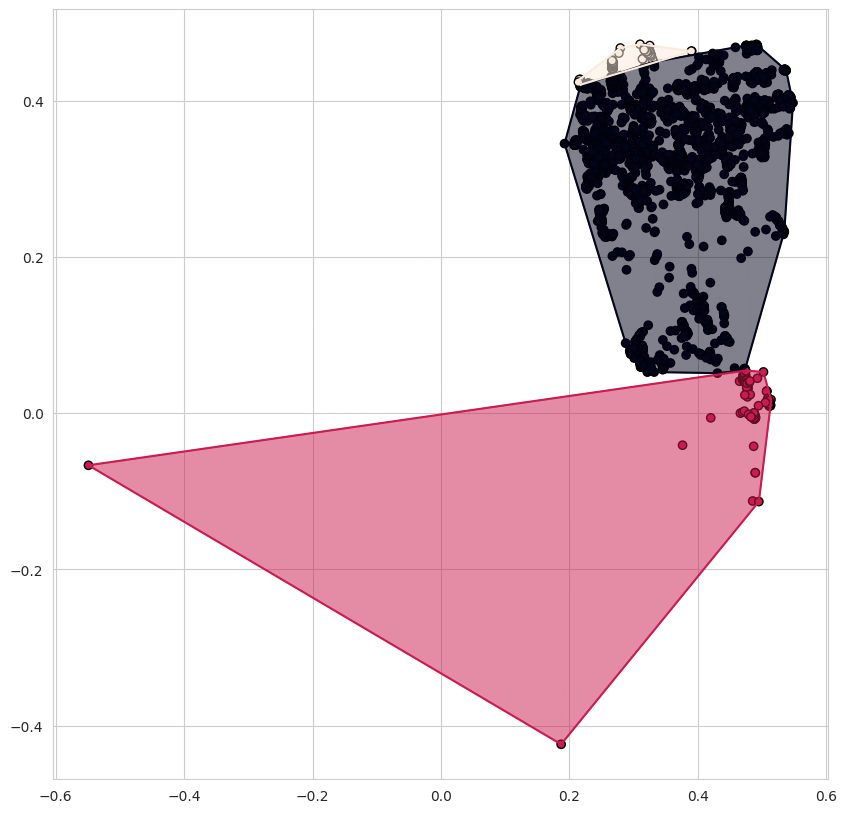

In [8]:
scanpath_visualization(tt[(tt['Participant'] == 1) & (tt['tekst'] == 2)], x="norm_pos_x", y="norm_pos_y", aoi="AOI", show_hull=True, with_axes=True)

In [9]:
pipeline = Pipeline([('AOIDefining', AOIExtractor(methods=[shape_based], x=x, y=y, pk=['Participant', 'tekst'], instance_columns=['tekst'], aoi_name='AOI', show_best=True))])
# pipeline = Pipeline([('AOIDefining', AOIExtractor(methods=methods, x=x, y=y, pk=['Participant', 'tekst'], instance_columns=['tekst'], aoi_name='AOI', show_best=True))])
pipeline.fit(data)
prep_data = pipeline.transform(data)

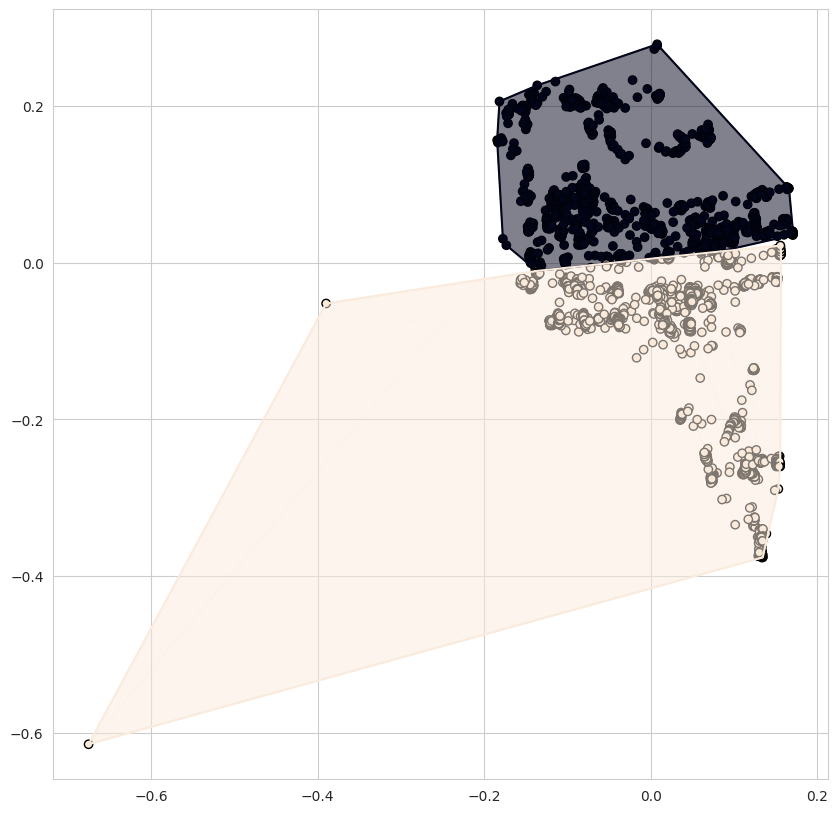

In [10]:
scanpath_visualization(prep_data[(prep_data['Participant'] == 1) & (prep_data['tekst'] == 3)], x="norm_pos_x", y="norm_pos_y", aoi="AOI", show_hull=True, with_axes=True)

In [11]:
ivt = IVT(x=x, y=y, t=t, pk=['Participant', 'tekst'], threshold=0.5, )
ivt_data = ivt.transform(data)
ivt_data.head()

,Participant,tekst,norm_pos_x,norm_pos_y,start_time,end_time,distance_min,distance_max,diameters,centers,duration,saccade_duration,saccade_length,saccade_angle,saccade2_angle
0,1,1,0.239834,0.516343,317242.708403,317242.721633,0.000195,0.002556,0.002556,"[0.24017877960158973, 0.5163239244528413]",0.013230,0.000000,0.000000,0.000000,0.000000
1,1,1,0.245384,0.505449,317242.735084,317242.835534,0.000179,0.002909,0.006973,"[0.24534965207218118, 0.5053153068756444]",0.100450,0.013452,0.012227,296.995807,7.746079
2,1,1,0.242721,0.509288,317242.847781,317242.847781,0.000712,0.000712,0.000000,"[0.2427212672736854, 0.5092879141035382]",0.000000,0.012247,0.004672,124.741886,179.430203
3,1,1,0.236628,0.517890,317242.861760,317242.877572,0.001193,0.001974,0.003286,"[0.23694195737802515, 0.517857872489202]",0.015812,0.013979,0.010541,125.311683,34.695069
4,1,1,0.236702,0.511007,317242.891984,317242.891984,0.002011,0.002011,0.000000,"[0.2367022278961963, 0.5110065167407356]",0.000000,0.014412,0.006884,270.616614,186.321744


In [12]:
overlap = OverlapClustering(x, y, "diameters", "centers", ['Participant', 'tekst'], "AOI", eps=0.01)
overlap.fit(ivt_data)
overlap_data = overlap.transform(ivt_data)
overlap_data.head()

,Participant,tekst,norm_pos_x,norm_pos_y,start_time,end_time,distance_min,distance_max,diameters,centers,duration,saccade_duration,saccade_length,saccade_angle,saccade2_angle,AOI
0,1,1,0.239834,0.516343,317242.708403,317242.721633,0.000195,0.002556,0.002556,"[0.24017877960158973, 0.5163239244528413]",0.013230,0.000000,0.000000,0.000000,0.000000,43
1,1,1,0.245384,0.505449,317242.735084,317242.835534,0.000179,0.002909,0.006973,"[0.24534965207218118, 0.5053153068756444]",0.100450,0.013452,0.012227,296.995807,7.746079,43
2,1,1,0.242721,0.509288,317242.847781,317242.847781,0.000712,0.000712,0.000000,"[0.2427212672736854, 0.5092879141035382]",0.000000,0.012247,0.004672,124.741886,179.430203,43
3,1,1,0.236628,0.517890,317242.861760,317242.877572,0.001193,0.001974,0.003286,"[0.23694195737802515, 0.517857872489202]",0.015812,0.013979,0.010541,125.311683,34.695069,43
4,1,1,0.236702,0.511007,317242.891984,317242.891984,0.002011,0.002011,0.000000,"[0.2367022278961963, 0.5110065167407356]",0.000000,0.014412,0.006884,270.616614,186.321744,43


In [13]:
overlap_data["AOI"].isnull().sum(), overlap_data.shape[0]

(0, 27420)

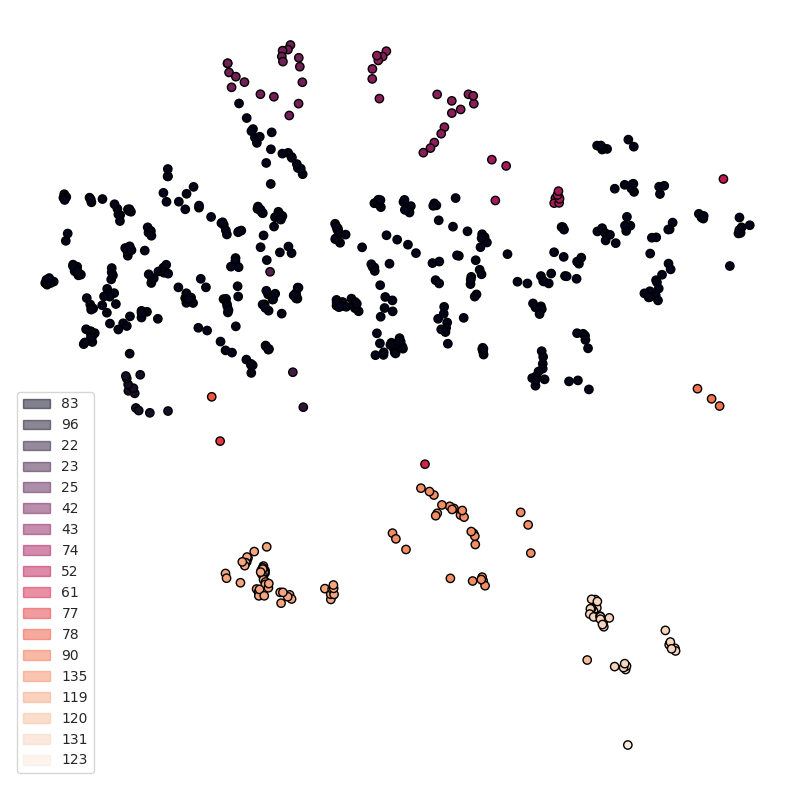

In [14]:
scanpath_visualization(overlap_data[(overlap_data['Participant'] == 1) & (overlap_data['tekst'] == 2)], x, y, aoi='AOI', only_points=True, show_legend=True)

In [15]:
x = 'norm_pos_x'
y = 'norm_pos_y'
t = 'gaze_timestamp'

data = pd.concat([pd.read_excel(join(DATA_PATH, 'itog_fix_1.xlsx')),
                  pd.read_excel(join(DATA_PATH, 'itog_fix_17.xlsx')),
                  pd.read_excel(join(DATA_PATH, 'itog_fix_18.xlsx')),
                  pd.read_excel(join(DATA_PATH, 'itog_fix_19.xlsx')),
                  pd.read_excel(join(DATA_PATH, 'itog_fix_20.xlsx')),
                  ], axis=0)

data = remove_points(data, -1, 1, -1, 1)

# methods = [ThresholdBased(threshold=0, window_size=3), GradientBased(threshold=0.0, window_size=6), KMeans(n_clusters=3)]
methods = [GradientBased(threshold=0.0, window_size=6), KMeans(n_clusters=3)]
pipeline = Pipeline([('AOIDefining', AOIExtractor(methods=methods, x=x, y=y, pk=['Participant', 'tekst'], instance_columns=['tekst'], aoi_name='AOI', show_best=True)), ('AOIMatcher', AOIMatcher(x=x, y=y, pk=['Participant', 'tekst'], instance_columns=['tekst'], aoi='AOI', n_aoi=3))])
# pipeline = Pipeline([('AOIDefining', AOIExtractor(methods=methods, x=x, y=y, pk=['Participant', 'tekst'], instance_columns=['tekst'], aoi_name='AOI', show_best=True))])
pipeline.fit(data)
prep_data = pipeline.transform(data)

FileNotFoundError: [Errno 2] No such file or directory: '../data/gazes/itog_fix_1.xlsx'

In [ ]:
scanpath_visualization(prep_data[(prep_data['Participant'] == 1) & (prep_data['tekst'] == 5)], x, y, aoi='AOI', only_points=True, show_legend=True)

In [ ]:
scanpath_visualization(prep_data[(prep_data['Participant'] == 17) & (prep_data['tekst'] == 5)], x, y, aoi='AOI', only_points=True, show_legend=True)

In [ ]:
scanpath_visualization(prep_data[(prep_data['Participant'] == 18) & (prep_data['tekst'] == 5)], x, y, aoi='AOI', only_points=True, show_legend=True)

In [ ]:
scanpath_visualization(prep_data[(prep_data['Participant'] == 1) & (prep_data['tekst'] == 8)], x, y, aoi='AOI', only_points=True, show_legend=True)

In [ ]:
scanpath_visualization(prep_data[(prep_data['Participant'] == 18) & (prep_data['tekst'] == 8)], x, y, aoi='AOI', only_points=True, show_legend=True)

In [ ]:
scanpath_visualization(prep_data[(prep_data['Participant'] == 1) & (prep_data['tekst'] == 9)], x, y, aoi='AOI', only_points=True, show_legend=True)

In [ ]:
prep_data.shape

In [ ]:
df = pd.concat([prep_data[prep_data['best_method'] == m.__class__.__name__].count() for m in methods], axis=1).transpose()
# df = pd.concat([prep_data[prep_data['best_method'] == methods[0].__class__.__name__].count(), prep_data[prep_data['best_method'] == methods[1].__class__.__name__].count()], axis=1).transpose()
df['Methods'] = [el.__class__.__name__ for el in methods]
df

In [ ]:
sns.barplot(x=df['Methods'], y=df['Participant'])

In [ ]:
window = 3
threshold = 0.0000001
data = pd.concat([pd.read_excel(join(DATA_PATH, 'itog_fix_1.xlsx')),
                  pd.read_excel(join(DATA_PATH, 'itog_fix_2.xlsx'))], axis=0)
data = remove_points(data, -1, 1, -1, 1)

In [ ]:
extr = AOIExtractor(methods=methods, x=x, y=y, pk=['Participant', 'tekst'], aoi_name='AOI', show_best=True)
extr.fit(data)
data_aoi = extr.transform(data)

In [ ]:
scanpath_visualization(data_aoi[(data_aoi['Participant'] == 1) & (data_aoi['tekst'] == 10)], x, y, aoi='AOI', only_points=True, show_legend=True)

In [ ]:
df = pd.concat([data_aoi[data_aoi['best_method'] == methods[0].__class__.__name__].count(), data_aoi[data_aoi['best_method'] == methods[1].__class__.__name__].count()], axis=1).transpose()
df['Methods'] = [el.__class__.__name__ for el in methods]
df

In [ ]:
sns.barplot(x=df['Methods'], y=df['Participant'])

In [ ]:
gradient_b = GradientBased(x=x, y=y, window_size=window, threshold=threshold, aoi_name="AOI", pk=['Participant', 'tekst'])

In [ ]:
res_grad = gradient_b.transform(data)

In [ ]:
scanpath_visualization(res_grad[(res_grad['Participant'] == 1) & (res_grad['tekst'] == 10)], x, y, aoi='AOI', only_points=True, show_legend=True)

In [ ]:
threshold_b = ThresholdBased(x=x, y=y, window_size=window, threshold=threshold, aoi_name="AOI", pk=['Participant', 'tekst'])

In [ ]:
data_thr = threshold_b.transform(data)
data_thr.head(15)

In [ ]:
scanpath_visualization(data_thr[(data_thr['Participant'] == 1) & (data_thr['tekst'] == 10)], x, y, aoi='AOI', only_points=True, show_legend=True)